In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy

import numpy as np 

import healpy as hp

import astropy.time
import astropy.units as u
import astropy.coordinates
from astropy.io import fits
from astropy.table import Table, Column
from astropy.time import Time, TimezoneInfo

import matplotlib.pyplot as plt

In [2]:
lsst, header = hp.read_map('data/opsim_nvisits_g.fits.gz', dtype=np.float, h=True, verbose=False)

lsst_mask = lsst > 1

/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and i

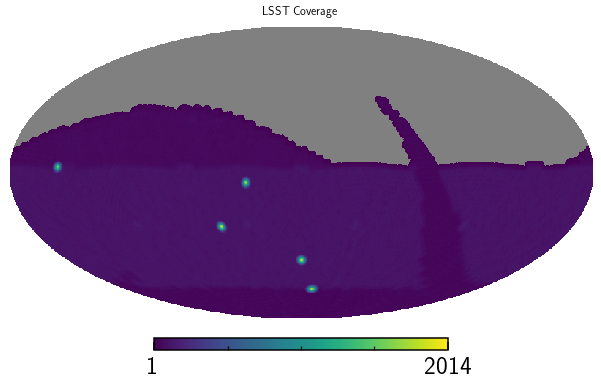

In [3]:
hp.mollview(lsst, title='LSST Coverage')

In [4]:
npix = len(lsst)
nside = hp.npix2nside(npix)

# Look up (celestial) spherical polar coordinates of HEALPix grid.
theta, phi = hp.pix2ang(nside, np.arange(npix))

# Convert to RA, Dec.
radecs = astropy.coordinates.SkyCoord(
    ra=phi * u.rad, dec=(0.5 * np.pi - theta) * u.rad)

In [5]:
ra_lsst = radecs.ra.value
dec_lsst = radecs.dec.value

In [6]:
las_campanas = astropy.coordinates.EarthLocation(
    lat=-29.0182*u.deg, lon=-70.6915*u.deg, height=2380*u.m)

leng_hu = astropy.coordinates.EarthLocation(
    lat=38.7348*u.deg, lon=93.3306*u.deg, height=3800*u.m)

china_new_year = Time('2020-01-01T18:00:00', scale='utc')
chile_new_year = Time('2020-01-01T05:00:00', scale='utc')

In [7]:
def map_observability(lsst, observatory, time, min_alt=30.):
    """"""
    # Determine resolution of sky map
    npix = len(lsst)
    nside = hp.npix2nside(npix)
    
    # Look up (celestial) spherical polar coordinates of HEALPix grid.
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    
    # Convert to RA, Dec.
    radecs = astropy.coordinates.SkyCoord(
        ra=phi * u.rad, dec=(0.5 * np.pi - theta) * u.rad)
    
    # Alt/az reference frame at observatory
    frame = astropy.coordinates.AltAz(
        obstime=time, location=observatory)
    
    # Transform grid to alt/az coordinates at observatory, now
    altaz = radecs.transform_to(frame)

    # Where is the sun, now?
    sun_altaz = astropy.coordinates.get_sun(time).transform_to(altaz)
    
    # Altitude
    alt = altaz.alt.value
    
    # Mask for the available pixel
    lsst_mask = (lsst > 1)
    available = ((sun_altaz.alt <= -20 * u.deg) & (alt > min_alt) & lsst_mask)
    
    alt[~available] = -1
    
    return {'time': time, 'alt': alt, 'available': available, 
            'frac': available.sum() / lsst_mask.sum()}

In [8]:
days = np.linspace(0, 365, int(365 / 5) + 1)

In [9]:
chile = [map_observability(lsst, las_campanas, chile_new_year + day) for day in days]

In [10]:
china = [map_observability(lsst, leng_hu, china_new_year + day) for day in days]

In [11]:
chile_table = Table(chile)
china_table = Table(china)

In [12]:
chile_available = np.any(np.asarray(chile_table['available']), axis=0)
china_available = np.any(np.asarray(china_table['available']), axis=0)

In [13]:
print(chile_available.sum() / lsst_mask.sum())
print(china_available.sum() / lsst_mask.sum())

0.991738316197171
0.5077381492944679


In [14]:
chile_max_alt = np.max(np.asarray(chile_table['alt']), axis=0)
china_max_alt = np.max(np.asarray(china_table['alt']), axis=0)

/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To 

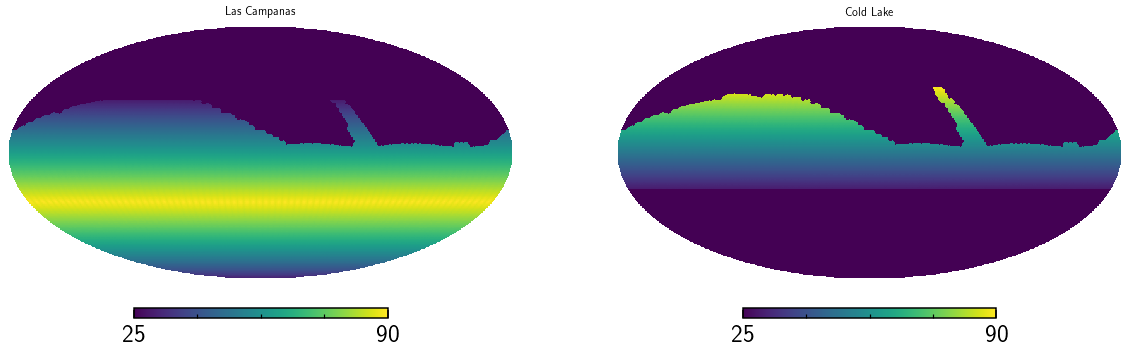

In [228]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
plt.axes(ax1)
hp.mollview(chile_max_alt, hold=True, title='Las Campanas', min=25, max=90.)

ax2 = fig.add_subplot(122)
plt.axes(ax2)
hp.mollview(china_max_alt, hold=True, title='Cold Lake', min=25, max=90)